# Predicting store sales values using Neural Network

This notebook demonstrates the entire process of building a predictive model using Keras sequential model to suggest store sales values.

In [16]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from sklearn.cross_validation  import train_test_split
from keras.optimizers import SGD
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [17]:
# read in data
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('store.csv')

In [18]:
# merge store data with train data
final = train.merge(stores, on='Store')

final.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [19]:
# Converted Date column in year-month format for further processing
final['Date'] = pd.to_datetime(final['Date'])

final['year_month'] = final['Date'].dt.year.map(str) + '-' + final['Date'].dt.month.map(str)

grouped_month = final.groupby(final['year_month']).sum()
grouped_month = grouped_month.reset_index()

grouped_month['year_month'] = pd.to_datetime(grouped_month['year_month'])

grouped_month = grouped_month.sort_values(by='year_month')
grouped_month = grouped_month.reset_index()

labels = grouped_month['year_month'].dt.year.map(str) + '-' + grouped_month['year_month'].dt.month.map(str)

In [20]:
train_cut = final.iloc[:10000, :]

Limit the model to the first 10,000 samples - for ease of computation

In [21]:
# Convert Store to float16 for faster runtime
train_cut['Store'] = train_cut['Store'].astype(np.float16)
train_cut.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,year_month
0,1.0,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-7
1,1.0,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-7
2,1.0,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-7
3,1.0,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-7
4,1.0,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-7


In [22]:
# convert catigorical variables to dummy indicators
train_2 = pd.get_dummies(train_cut, columns=['Store', 'DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment', 'year_month'])

In [23]:
# drop extraneous features
train_2.drop(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'], axis=1, inplace=True)

In [24]:
# normalize label
labels = (train_2['Sales'] - train_2['Sales'].mean(axis=0)) / train_2['Sales'].std(axis=0, ddof=1)

In [25]:
# remove label columns from training set
train_2 = train_2.iloc[:, 3:]

In [26]:
# convert to float16 for faster runtime
train_2 = train_2.astype(np.float16)
labels = labels.astype(np.float16)

## Keras Sequential Model

In [27]:
# split data in training and test
x_train, x_valid, y_train, y_valid  = train_test_split(train_2, 
                                                     labels, 
                                                     test_size=0.30, 
                                                     random_state=42)

In [28]:
# convert DataFrame to numpy array
x_train = x_train.values
y_train = y_train.values

x_valid = x_valid.values
y_valid = y_valid.values

In [29]:
# build sequential neural network model with:
# 150 hidden units
# 0.2 dropout regularizer
# relu activation function
# mean squared error loss function
# stochastic gradient descent optimizer
model = Sequential()
model.add(Dense(output_dim=150, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(output_dim=1))

model.add(Dense(output_dim=150, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(output_dim=1))

model.add(Dense(output_dim=150, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(output_dim=1))

model.add(Dense(output_dim=150, input_dim=np.shape(x_train)[1]))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(output_dim=1))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='sgd')
# fit model to data
history = model.fit(x_train, y_train, verbose=0, nb_epoch=200, batch_size=3000, validation_data=(x_valid, y_valid))
Y_pred = model.predict(x_train)
score = model.evaluate(x_train, y_train, batch_size=3000)
print ('Training score %.2f' % (score * 100))
score = model.evaluate(x_valid, y_valid, batch_size=3000)
print ('Validation score %.2f' % (score * 100))

7000/7000 [==============================] - 0s 8us/step
Training score 50.53
3000/3000 [==============================] - 0s 8us/step
Validation score 49.50


## Results - Training/Validation

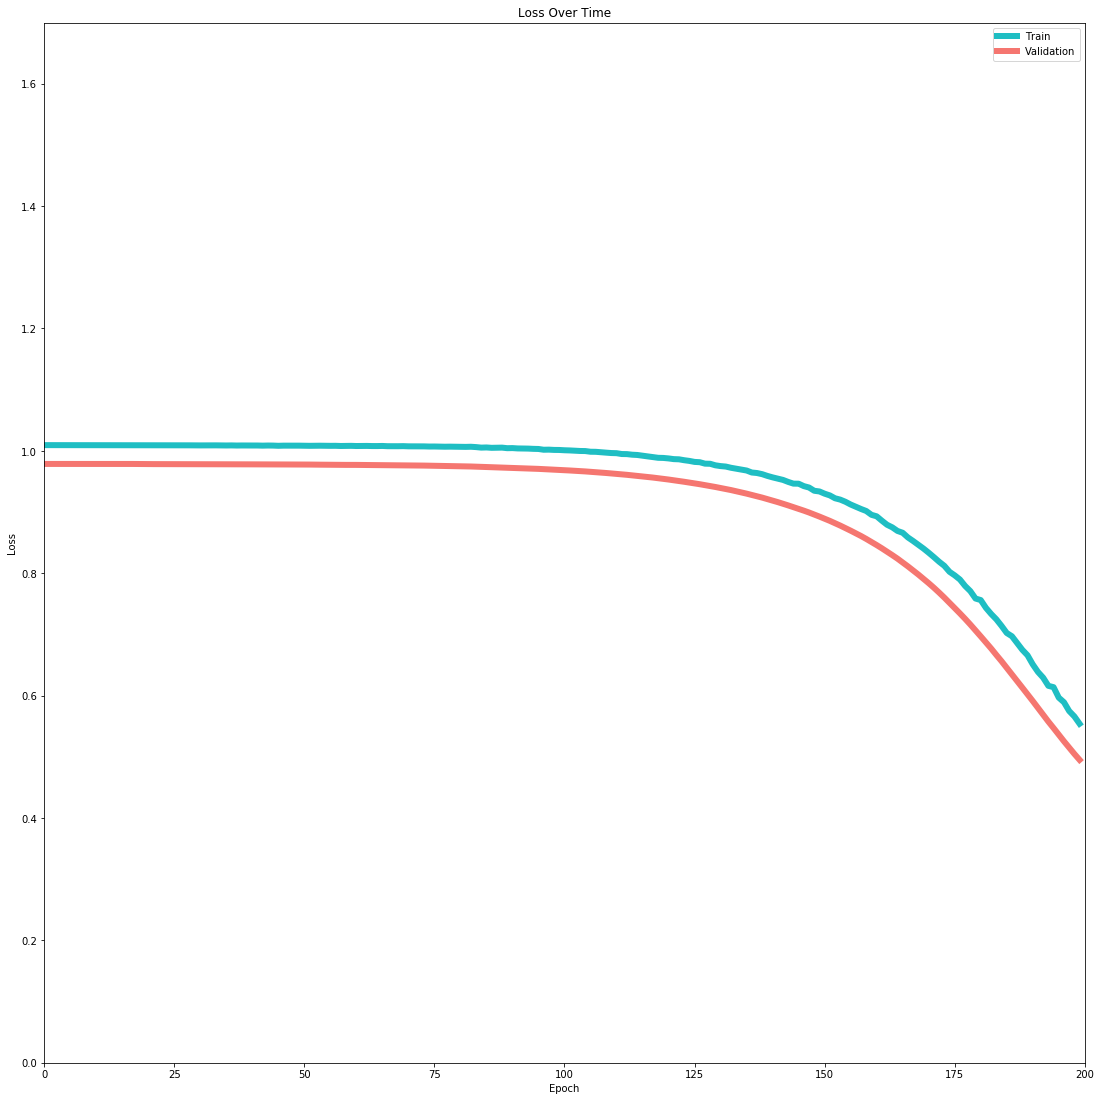

In [30]:
fig = plt.figure(figsize=(30,30))
plt.subplot(222)
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1.7])
plt.xlim([0,200])
    
train = plt.plot(history.epoch, history.history['loss'], color='#1FBEC3', label='Train', linewidth=6)
val = plt.plot(history.epoch, history.history['val_loss'], color='#F57670', label='Validation', linewidth=6)
plt.legend(loc='upper right')

plt.tight_layout()

<h2>References</h2>
<ul>
    <p>Neural network model for Rossmann store sales</p>
<li>https://github.com/SomeSnm/rossmann_kaggle/blob/master/Rossman_solution.ipynb</li>
    <p>Keras guide to build a sequential model</p>
<li>https://keras.io/getting-started/sequential-model-guide/</li>
    <p>Step by step process to build a neural network in keras</p>
<li>https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/</li>
</ul>